#### Music genre classification with CoversBR dataset

There are different music genres, for example, pop, country, hip-hop and mpb. Each genre is classified by different factors as composition, frequency, loudness, etc. Automate the classification of song's genres can reduce time for manual tasks and also help recommendation systems for example.

In this demonstration we are going to work with CoversBR dataset. CoversBR is the first large audio database with, predominantly, Brazilian music. The dataset is composed of metadata and features extracted from 102298 songs, distributed in 26366 groups of covers/versions, with an average of 3.88 versions per group. The entire collection adds up to a total of approximately 7070 hours and the average song length is 240 seconds (4 minutes).

* [Downloading dataset from AWS Open Data](#section-one)
* [Exploratory data analysis](#section-two)
* [Training and Evaluating](#section-three)
    - [Preparing train, validation and test data](#subsection-two)
    - [Artificial Neural Network](#subsection-three)
    - [Testing](#subsection-four)

In [2]:
!pip install --upgrade cython scikit-learn
!pip install deepdish essentia librosa pytube

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


<a id="section-one"></a>
# Downloading dataset from AWS Open Data

data source: https://registry.opendata.aws/covers-br/

In [3]:
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config

In [4]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket = 'covers-song-br'

In [5]:
s3.download_file(bucket, 'CoversBR_metadata.csv', 'CoversBR_metadata.csv')

In [6]:
def download_pre_extracted_features(work_id, track_id):
    if not os.path.exists(f'features-h5/{work_id}'):
        os.makedirs(f'features-h5/{work_id}')
    s3.download_file(bucket, f'features-h5/{work_id}/{track_id}.h5', f'features-h5/{work_id}/{track_id}.h5')

<a id="section-two"></a>
# EDA (Exploratory Data Analysis)

In [7]:
import numpy as np
import pandas as pd
import deepdish as dd
from datetime import datetime

In [8]:
df = pd.read_csv("CoversBR_metadata.csv", delimiter=";")
df.head()

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
0,1,ADMIRAVEL GADO NOVO,19629,CASSIA ELLER,CD,ND,STUDIO,00:04:35.07,11025,8311499a-4e40-4afc-a826-6725d8454851,T0391535844,BRPGD9600090,BR,96
1,1,ADMIRAVEL GADO NOVO,23880,ZE RAMALHO,CD,ND,STUDIO,00:05:06.69,11025,1ec54f25-7525-480a-b7fa-4c79fc2ee05f,T0391535844,BRBMG9700282,BR,97
2,1,ADMIRAVEL GADO NOVO,579191,BIQUINI CAVADAO,IMPORTACAO,ND,STUDIO,00:04:21.77,11025,880622cf-96fd-4211-850f-9f914a5244c6,T0391535844,BRSME9400075,BR,94
3,1,ADMIRAVEL GADO NOVO,705173,OSWALDO MONTENEGRO,CD,ND,STUDIO,00:04:57.23,11025,23d08080-8113-47ea-b712-65acf448252f,T0391535844,BRABZ0300234,BR,03
4,1,ADMIRAVEL GADO NOVO,2164817,CASSIA ELLER,ND,ND,STUDIO,00:02:51.96,11025,ND,T0391535844,BRMCA9000102,BR,90


In [9]:
df.shape

(102298, 14)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102298 entries, 0 to 102297
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   work_id            102298 non-null  int64 
 1   Music_Name         102298 non-null  object
 2   track_id           102298 non-null  int64 
 3   Artist_Name        102298 non-null  object
 4   Source             102298 non-null  object
 5   Genre_ECAD         102298 non-null  object
 6   Recording_Version  102298 non-null  object
 7   Duration           102298 non-null  object
 8   Fs                 102298 non-null  int64 
 9   MBID               102298 non-null  object
 10  ISWC               102298 non-null  object
 11  ISRC               102298 non-null  object
 12  Country            102298 non-null  object
 13  Year               102298 non-null  object
dtypes: int64(3), object(11)
memory usage: 10.9+ MB


In [11]:
df["Genre_ECAD"].nunique()

48

There are **48** music genres.

The dataset is composed with pre-extracted features utilizing open-source feature extraction libraries such as [Essentia](https://essentia.upf.edu/), [LibROSA](https://librosa.org/doc/latest/index.html), and [Madmom](https://github.com/CPJKU/madmom).

In [12]:
download_pre_extracted_features('1', '19629')

In [13]:
features_h5 = dd.io.load("features-h5/1/19629.h5")
features_h5

{'chroma_cens': array([[0.29958424, 0.3143753 , 0.26644658, ..., 0.28923238, 0.34345919,
         0.3024843 ],
        [0.29899476, 0.31037456, 0.26645299, ..., 0.28897118, 0.34255396,
         0.30529574],
        [0.29842526, 0.30647505, 0.26637195, ..., 0.28876616, 0.34130636,
         0.30770652],
        ...,
        [0.22426133, 0.25230793, 0.20553342, ..., 0.36653082, 0.50311212,
         0.27132577],
        [0.22999659, 0.25213725, 0.19852104, ..., 0.37457822, 0.50369016,
         0.2721176 ],
        [0.23506356, 0.25191737, 0.19121736, ..., 0.38250976, 0.50370684,
         0.27282924]]),
 'crema': array([[0.02041042, 0.298967  , 0.31116188, ..., 0.4366108 , 0.02329016,
         0.15784612],
        [0.02041042, 0.298967  , 0.31116188, ..., 0.4366108 , 0.02329016,
         0.15784612],
        [0.02041042, 0.298967  , 0.31116188, ..., 0.4366108 , 0.02329016,
         0.15784612],
        ...,
        [0.03430519, 0.4069843 , 0.12141854, ..., 0.47511283, 0.01160776,
         0

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import essentia.standard as estd

%matplotlib inline

### Which are the countries with more songs?

In [15]:
df["Country"].value_counts(normalize=True)

BR     0.401406
US     0.280778
GB     0.100530
ND     0.082093
DE     0.045465
NL     0.016589
FR     0.012170
BX     0.011838
NDI    0.011300
SE     0.006941
AR     0.004937
IT     0.004213
AU     0.003558
JP     0.002678
CA     0.002532
ES     0.002033
DK     0.001603
CH     0.001378
QM     0.001310
FI     0.000938
MX     0.000802
BE     0.000528
PT     0.000450
NO     0.000450
PL     0.000420
IN     0.000391
UK     0.000362
ZA     0.000293
AT     0.000244
CY     0.000225
GE     0.000215
IE     0.000205
NZ     0.000176
HK     0.000156
GR     0.000147
RO     0.000108
RU     0.000088
CO     0.000078
KR     0.000059
CZ     0.000059
SG     0.000049
AE     0.000049
TC     0.000029
SU     0.000020
TW     0.000020
QZ     0.000020
MY     0.000020
PH     0.000020
PE     0.000010
BA     0.000010
BB     0.000010
Name: Country, dtype: float64

About **40%** of the database is composed of Brazilian music.

### What are the musics genres?

In [16]:
df['Genre_ECAD'].value_counts(normalize=True)

ND               0.959237
MPB              0.005748
GOSPEL           0.005484
SERTANEJO        0.004712
EVANGELICA       0.003685
SAMBA            0.003216
ROMANTICO        0.003079
RELIGIOSO        0.002170
FORRO            0.001417
PAGODE           0.001320
BOSSA NOVA       0.001183
CLASSICA         0.001153
POP MUSIC        0.001046
SAMBA CANCAO     0.000997
SAMBA ENREDO     0.000978
ROCK             0.000792
CHORO            0.000401
CATOLICO         0.000303
XOTE             0.000254
DANCE MUSIC      0.000196
HEAVY METAL      0.000186
VANEIRAO         0.000186
MARCHA           0.000186
TOADA            0.000176
FREVO            0.000166
HINO             0.000137
RAP              0.000137
REGIONAL         0.000117
CANCAO           0.000117
BALADA           0.000108
TANGO            0.000108
FOX-TROT         0.000108
OUTROS           0.000098
FUNK             0.000098
AXE MUSIC        0.000098
BOLERO           0.000098
INSTRUMENTAL     0.000078
SACRA            0.000059
BAIAO       

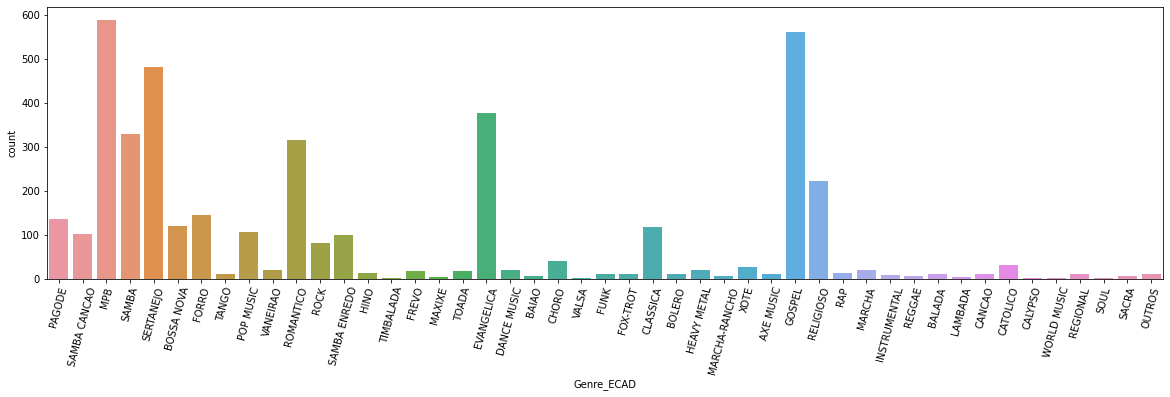

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(data=df[df['Genre_ECAD'] != 'ND'], x='Genre_ECAD')
plt.xticks(plt.xticks()[0], rotation=75)
plt.show()

The dataset is not balanced for this use case. It is possible to down-sampling the dominant class, up-sampling the rare class, do data augmentation or work with sample weights during training.

Focusing in top3 genres

In [18]:
genres = df[df['Genre_ECAD'] != 'ND']['Genre_ECAD'].value_counts().nlargest(3).index.tolist()
genres

['MPB', 'GOSPEL', 'SERTANEJO']

In [19]:
df.loc[df['Genre_ECAD'] == 'MPB'].head()

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
170,55,PACIENTE,53969,HENRIQUE CAZES/MARCELLO GONCALVES,CD,MPB,TAPE,00:03:52.07,11025,ND,ND,ND,BR,ND
171,55,PACIENTE,1707695,JACOB DO BANDOLIM,CAPTACAO RADIO,MPB,LIVE (AO VIVO),00:03:48.00,11025,8201335d-73ba-4d49-9b4c-9dd6eaa04968,ND,ND,BR,ND
215,82,UM CHOPE PRA DISTRAIR,46992,ADIL TISCATTI,CAPTACAO RADIO,MPB,STUDIO,00:04:05.00,11025,ND,T0390967459,BRVLS0000039,BR,00
216,82,UM CHOPE PRA DISTRAIR,249136,EMILIO SANTIAGO,CD,MPB,STUDIO,00:04:34.07,11025,ND,T0390967459,ND,BR,ND
217,82,UM CHOPE PRA DISTRAIR,994838,PAULO DINIZ,CAPTACAO RADIO,MPB,STUDIO,00:02:10.01,11025,2954e162-3810-4d34-9651-5cebdbc20fbb,T0390967459,BRGVC0500195,BR,05


In [20]:
df.loc[df['Genre_ECAD'] == 'SERTANEJO'].head()

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
244,98,AI AMOR,43094,LUCINHA,CD,SERTANEJO,STUDIO,00:03:31.73,11025,ND,T0390261865,BREMI9900323,BR,99
245,98,AI AMOR,830180,REGINALDO ROSSI,CD,SERTANEJO,STUDIO,00:03:24.24,11025,3a95a1fb-3112-449f-8a9a-29361e27b124,T0390261865,ND,BR,ND
246,98,AI AMOR,2500978,REGINALDO ROSSI,CD,SERTANEJO,STUDIO,00:03:24.08,11025,3a95a1fb-3112-449f-8a9a-29361e27b124,T0390261865,BREMI8400142,BR,84
420,189,CACADOR DE CORACOES,10237,GIAN/GIOVANI,CD,SERTANEJO,STUDIO,00:03:42.73,11025,ND,T0393084688,ND,BR,ND
421,189,CACADOR DE CORACOES,1232276,GIAN/GIOVANI/CESAR MENOTTI/FABIANO,CD,SERTANEJO,LIVE (AO VIVO),00:03:06.63,11025,ND,T0393084688,BRAPI0701389,BR,07


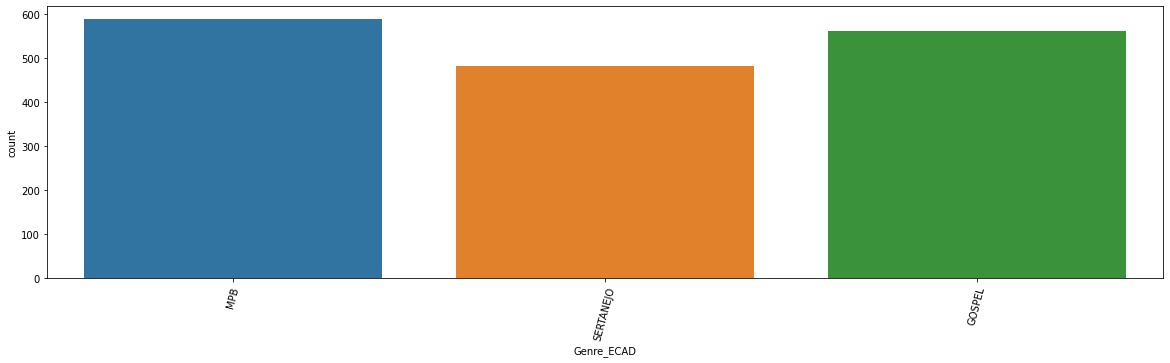

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(data=df.loc[df['Genre_ECAD'].isin(genres)], x='Genre_ECAD')
plt.xticks(plt.xticks()[0], rotation=75)
plt.show()

### The features are similar between two covers?

In [22]:
df.loc[df['track_id'] == 1707695]

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
171,55,PACIENTE,1707695,JACOB DO BANDOLIM,CAPTACAO RADIO,MPB,LIVE (AO VIVO),00:03:48.00,11025,8201335d-73ba-4d49-9b4c-9dd6eaa04968,ND,ND,BR,ND


In [23]:
work1_id = 55 # MPB
work2_id = 98 # SERTANEJO

track1_id = 53969 # query audio
track2_id = 1707695 # true cover
track3_id = 43094 # false cover

download_pre_extracted_features(work1_id, track1_id)
download_pre_extracted_features(work1_id, track2_id)
download_pre_extracted_features(work2_id, track3_id)

In [24]:
for dirname, _, filenames in os.walk('features-h5'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

features-h5/55/1707695.h5
features-h5/55/53969.h5
features-h5/98/43094.h5
features-h5/1/19629.h5


In [25]:
df.loc[df['track_id'] == track1_id]

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
170,55,PACIENTE,53969,HENRIQUE CAZES/MARCELLO GONCALVES,CD,MPB,TAPE,00:03:52.07,11025,ND,ND,ND,BR,ND


In [26]:
df.loc[df['track_id'] == track2_id]

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
171,55,PACIENTE,1707695,JACOB DO BANDOLIM,CAPTACAO RADIO,MPB,LIVE (AO VIVO),00:03:48.00,11025,8201335d-73ba-4d49-9b4c-9dd6eaa04968,ND,ND,BR,ND


In [27]:
df.loc[df['track_id'] == track3_id]

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
244,98,AI AMOR,43094,LUCINHA,CD,SERTANEJO,STUDIO,00:03:31.73,11025,ND,T0390261865,BREMI9900323,BR,99


In [28]:
hpcp_track1 = dd.io.load(f"features-h5/{work1_id}/{track1_id}.h5")['hpcp']
hpcp_track2 = dd.io.load(f"features-h5/{work1_id}/{track2_id}.h5")['hpcp']
hpcp_track3 = dd.io.load(f"features-h5/{work2_id}/{track3_id}.h5")['hpcp']

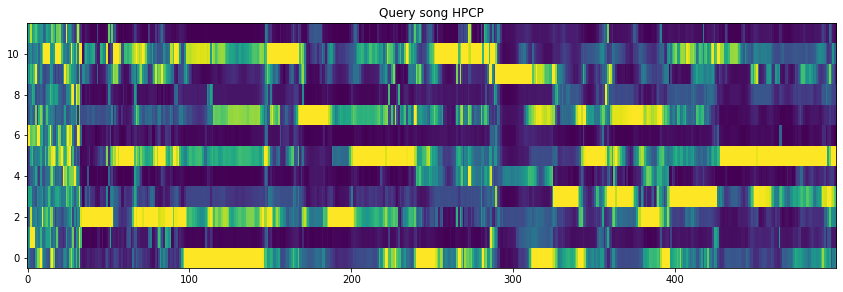

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14.5, 4.5)

plt.title("Query song HPCP")
plt.imshow(hpcp_track1[:500].T, aspect='auto', origin='lower', interpolation='none')

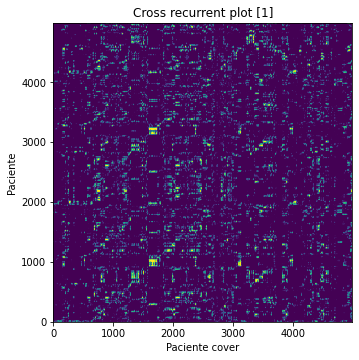

In [30]:
crp = estd.ChromaCrossSimilarity(frameStackSize=9,
                                 frameStackStride=1,
                                 binarizePercentile=0.095,
                                 oti=True)

true_pair_crp = crp(hpcp_track1[:5000], hpcp_track2[:5000])

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cross recurrent plot [1]')
plt.xlabel('Paciente cover')
plt.ylabel('Paciente')
plt.imshow(true_pair_crp, origin='lower')

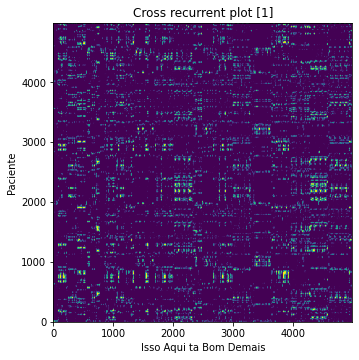

In [31]:
crp = estd.ChromaCrossSimilarity(frameStackSize=9,
                                 frameStackStride=1,
                                 binarizePercentile=0.095,
                                 oti=True)

false_pair_crp = crp(hpcp_track1[:5000], hpcp_track3[:5000])

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cross recurrent plot [1]')
plt.xlabel('Isso Aqui ta Bom Demais')
plt.ylabel('Paciente')
plt.imshow(false_pair_crp, origin='lower')

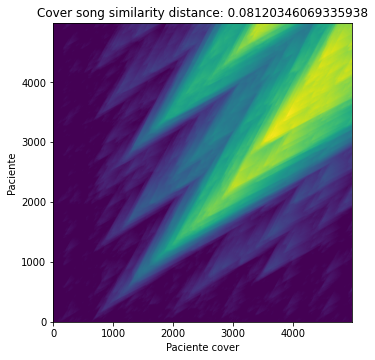

In [32]:
score_matrix, distance = estd.CoverSongSimilarity(disOnset=0.5,
                                                  disExtension=0.5,
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(true_pair_crp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cover song similarity distance: %s' % distance)
plt.xlabel('Paciente cover')
plt.ylabel('Paciente')
plt.imshow(score_matrix, origin='lower')

In [33]:
display(f'Cover song similarity distance: {distance}')

'Cover song similarity distance: 0.08120346069335938'

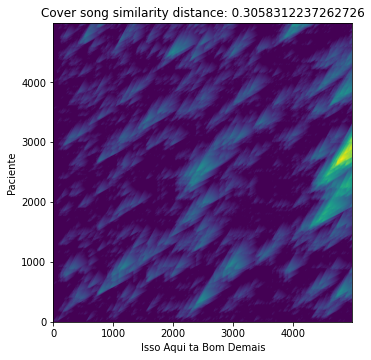

In [34]:
score_matrix, distance = estd.CoverSongSimilarity(disOnset=0.5,
                                                  disExtension=0.5,
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(false_pair_crp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cover song similarity distance: %s' % distance)
plt.xlabel('Isso Aqui ta Bom Demais')
plt.ylabel('Paciente')
plt.imshow(score_matrix, origin='lower')

In [35]:
display(f'Cover song similarity distance: {distance}')

'Cover song similarity distance: 0.3058312237262726'

As expected, for track1 and track2 the cover song similarity distance is lower than the track1 and track3 that are not covers.

### The features are similar between genres?

In [36]:
work3_id = 82
track4_id = 249136
download_pre_extracted_features(work3_id, track4_id)

In [37]:
df.loc[df['track_id'] == track4_id]

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
216,82,UM CHOPE PRA DISTRAIR,249136,EMILIO SANTIAGO,CD,MPB,STUDIO,00:04:34.07,11025,ND,T0390967459,ND,BR,ND


In [38]:
hpcp_track4 = dd.io.load(f"features-h5/{work3_id}/{track4_id}.h5")['hpcp']

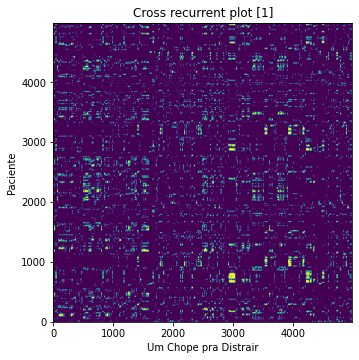

In [39]:
crp = estd.ChromaCrossSimilarity(frameStackSize=9,
                                 frameStackStride=1,
                                 binarizePercentile=0.095,
                                 oti=True)

genre_pair_crp = crp(hpcp_track1[:5000], hpcp_track4[:5000])

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cross recurrent plot [1]')
plt.xlabel('Um Chope pra Distrair')
plt.ylabel('Paciente')
plt.imshow(genre_pair_crp, origin='lower')

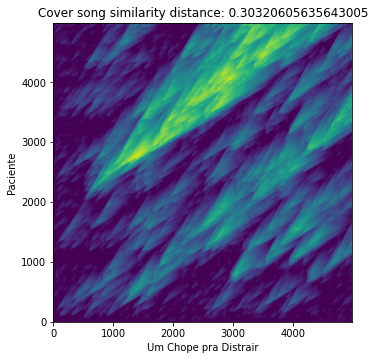

In [40]:
score_matrix, distance = estd.CoverSongSimilarity(disOnset=0.5,
                                                  disExtension=0.5,
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(genre_pair_crp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cover song similarity distance: %s' % distance)
plt.xlabel('Um Chope pra Distrair')
plt.ylabel('Paciente')
plt.imshow(score_matrix, origin='lower')

In [41]:
display(f'Cover song similarity distance: {distance}')

'Cover song similarity distance: 0.30320605635643005'

Cover song similarity distance is lower with different tracks and same genres. Let's try to utilize a ML model to classify the genres utilizing the other features available in the dataset.

<a id="section-three"></a>
# Training and Evaluating

<a id="subsection-two"></a>
## Preparing train, validation and test data

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

set_config(display='diagram')

In [43]:
def get_features(work_id, track_id):
    download_pre_extracted_features(work_id, track_id)
    features = dd.io.load(f"features-h5/{work_id}/{track_id}.h5")
    
    hpcp = np.mean(features['hpcp'], axis=0)
    chroma_cens = np.mean(features['chroma_cens'], axis=0)
    
    feature_matrix = np.array([])
    feature_matrix = np.hstack((hpcp, chroma_cens))
    
    return feature_matrix

The entire dataset has ~500GB, for demonstration purpose let's minimize in 50 tracks for top 3 genres and 2 tracks for each work_id.

In [45]:
df_genres = df.loc[df['Genre_ECAD'].isin(genres)]
genres_groups = df_genres.groupby('Genre_ECAD')
train_df = []
n_tracks_per_group = 50

for group_name, genre_group in genres_groups:
    genre_work_groups = genre_group.groupby('work_id')
    for work_id in list(genre_work_groups.groups)[:n_tracks_per_group]:
        row = df_genres.loc[df_genres['work_id']==work_id].iloc[0]
        train_df.append(row[['work_id', 'track_id', 'Genre_ECAD']].to_dict())

train_df = pd.DataFrame(train_df)
train_df.head(10)

,work_id,track_id,Genre_ECAD
0,27932,259818,GOSPEL
1,39758,312228,GOSPEL
2,40429,50437,GOSPEL
3,60175,352123,GOSPEL
4,89765,396683,GOSPEL
5,186926,45947,GOSPEL
6,281049,22431,GOSPEL
7,752060,472412,GOSPEL
8,774872,2065611,GOSPEL
9,1583461,981214,GOSPEL


In [46]:
le = LabelEncoder()
le.fit(train_df['Genre_ECAD'])
train_df['Genre_ECAD'] = le.transform(train_df['Genre_ECAD'])
list(le.classes_)

['GOSPEL', 'MPB', 'SERTANEJO']

In [47]:
train_df['Genre_ECAD'].unique()

array([0, 1, 2])

In [48]:
from tqdm import tqdm

X,y = [], []

for i, track in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    features = get_features(track['work_id'], track['track_id'])
    X.append(features)
    y.append(track['Genre_ECAD'])

100%|██████████| 150/150 [01:33<00:00,  1.61it/s]


In [50]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((150, 24), (150,))

In [51]:
pd.DataFrame(X, y).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.620678,0.159106,0.514401,0.193313,0.472084,0.390375,0.219270,0.608369,0.209312,0.467704,...,0.206750,0.235741,0.293525,0.286633,0.221993,0.183066,0.248080,0.291090,0.227922,0.186866
0,0.572614,0.227047,0.439922,0.467002,0.260536,0.474078,0.214573,0.490041,0.354529,0.352023,...,0.173914,0.180674,0.184405,0.190522,0.227429,0.236405,0.265748,0.253452,0.242623,0.251850
0,0.628175,0.117403,0.418544,0.207798,0.311475,0.697492,0.110741,0.467883,0.140688,0.455139,...,0.364956,0.303959,0.179784,0.168067,0.228313,0.233649,0.292191,0.318329,0.250329,0.137177
0,0.497454,0.229348,0.448343,0.505673,0.242988,0.559300,0.199331,0.458108,0.326404,0.328323,...,0.207541,0.185640,0.195866,0.211618,0.259862,0.279495,0.236925,0.193337,0.250251,0.276535
0,0.722431,0.204845,0.554640,0.246154,0.489039,0.496442,0.255893,0.721430,0.255259,0.521325,...,0.217860,0.235998,0.275100,0.250501,0.206692,0.164256,0.253289,0.326808,0.267053,0.182273


In [52]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,
    random_state=1,
    stratify=y # balanced categories between train and test
)

# test val split
X_val, X_test, y_val, y_test = train_test_split(
    X_test,                                             
    y_test,
    test_size=0.2,
    random_state=1,
    stratify=y_test # balanced categories between test and val
)

In [53]:
X_train.shape, X_test.shape, X_val.shape

((105, 24), (9, 24), (36, 24))

<a id="subsection-three"></a>
## ANN (Artificial Neural Network)

In [54]:
import tensorflow as tf
from tensorflow import keras as k

In [55]:
def build_model():
    model = k.models.Sequential([
        k.layers.Dense(
            512,
            activation='relu',
            input_shape=(X_train.shape[1],)
        ),
        k.layers.Dropout(0.2),

        k.layers.Dense(
            256,
            activation='relu'
        ),
        k.layers.Dropout(0.2),

        k.layers.Dense(
            128,
            activation='relu'
        ),
        k.layers.Dropout(0.2),

        k.layers.Dense(
            64,
            activation='relu'
        ),
        k.layers.Dropout(0.2),

        k.layers.Dense(
            10,
            activation='softmax'
        )
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics='accuracy'
    )

    return model

In [56]:
model = build_model()

model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=16
)

Epoch 1/1000
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-11-21 20:09:50.243 tensorflow-2-6-cpu-py-ml-t3-xlarge-d1755ee3394d1ac1254226dec0bd:22567 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-21 20:09:50.416 tensorflow-2-6-cpu-py-ml-t3-xlarge-d1755ee3394d1ac1254226dec0bd:22567 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
7/7 [==============================] - 1s 43ms/step - loss: 2.1201 - accuracy: 0.3143 - val_loss: 1.7636 - val_accuracy: 0.3333
Epoch 2/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.5762 - accuracy: 0.2762 - val_loss: 1.2404 - val_accuracy: 0.3333
Epoch 3/1000
7/7 [====

In [57]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=16)
display('Loss:', test_loss)
display('Accuracy:', test_acc*100)

1/1 [==============================] - 0s 29ms/step - loss: 1.6027 - accuracy: 0.6667


'Loss:'

1.6027075052261353

'Accuracy:'

66.66666865348816

<a id="subsection-four"></a>
## Testing

In [58]:
import librosa
from essentia import Pool, array, run
from pytube import YouTube
from IPython.display import Audio

In [82]:
url = "https://youtu.be/7-nIMtLql7Y"

video = YouTube(url).streams.filter(only_audio=True).first()
video.download(filename="sample.mp3")

Audio('sample.mp3')

In [83]:
def extract_croma_cens(audio, sampling_rate):
    chroma_cens = librosa.feature.chroma_cens(
        y=audio,
        sr=sampling_rate,
        hop_length=512
    )

    return chroma_cens.T

def extract_hpcp(audio, sampling_rate):
    frameGenerator = estd.FrameGenerator(audio, frameSize=4096, hopSize=512)
    windowing = estd.Windowing(type='blackmanharris62')
    spectrum = estd.Spectrum()

    spectralPeaks = estd.SpectralPeaks(
        magnitudeThreshold=0,
        maxFrequency=3500,
        minFrequency=100,
        maxPeaks=100,
        orderBy="frequency",
        sampleRate=sampling_rate
    )

    spectralWhitening = estd.SpectralWhitening(
        maxFrequency= 100,
        sampleRate=sampling_rate
    )

    hpcp = estd.HPCP(
        sampleRate=sampling_rate,
        maxFrequency=3500,
        minFrequency=100,
        referenceFrequency=440,
        nonLinear=False,
        harmonics=8,
        size=12
    )
    
    pool = Pool()

    #compute hpcp for each frame and add the results to the pool
    for frame in frameGenerator:
        spectrum_mag = spectrum(windowing(frame))
        frequencies, magnitudes = spectralPeaks(spectrum_mag)
        
        w_magnitudes = spectralWhitening(
            spectrum_mag,
            frequencies,
            magnitudes
        )
        hpcp_vector = hpcp(frequencies, w_magnitudes)
            
        pool.add('tonal.hpcp',hpcp_vector)

    return pool['tonal.hpcp']

In [84]:
audio, sr = librosa.load('sample.mp3')

/usr/local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [85]:
def extract_features(audio, sampling_rate):
    hpcp = np.mean(extract_hpcp(audio, sampling_rate), axis=0)
    chroma_cens = np.mean(extract_croma_cens(audio, sampling_rate), axis=0)
    
    feature_matrix = np.array([])
    feature_matrix = np.hstack((hpcp, chroma_cens))
    
    return feature_matrix

In [86]:
test_features = extract_features(audio, sr)
test = np.array([test_features])
pd.DataFrame(test).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.218752,0.269386,0.234413,0.511745,0.206483,0.409069,0.328436,0.24971,0.356629,0.167873,...,0.288266,0.276639,0.261151,0.253256,0.224254,0.369751,0.200177,0.117158,0.147385,0.157622


In [87]:
genres

['MPB', 'GOSPEL', 'SERTANEJO']

In [88]:
prediction = model.predict(test)
display(f"Confidence: {np.max(prediction[0]):.2f}, Genre: {genres[np.argmax(prediction[0])]}")

'Confidence: 0.99, Genre: MPB'